<font color = "DeepSkyBlue">**House Prices: Complete Stacked Ensemble with LightGBM, XGBoost, CatBoost + Optuna Tuning + Visuals**

This pipeline is a comprehensive solution for the Kaggle House Prices regression competition. It begins by loading the training and test datasets and applying a logarithmic transformation to the target variable (SalePrice) to stabilize variance and improve model performance. To ensure consistent feature engineering, the training and test sets are concatenated into a single DataFrame. Missing values are imputed using either the mode for categorical variables or the median for numerical ones. All categorical variables are label-encoded to convert them into numeric format suitable for modeling.

Several engineered features are introduced to capture important patterns, such as total square footage (TotalSF), total bathroom count (TotalBath), and house age (Age). Once preprocessing is complete, the dataset is split back into the original training and test sets.

For model optimization, Optuna is used to tune LightGBM hyperparameters efficiently. The most important hyperparameters discovered during the search are visualized using Optuna’s built-in importance plots. Three gradient boosting models are prepared: LightGBM (with tuned parameters), XGBoost, and CatBoost. Each model undergoes 5-fold cross-validation, during which out-of-fold (OOF) predictions are generated for stacking, and test predictions are averaged across folds.

SHAP (SHapley Additive exPlanations) values are computed for each model to interpret feature importance, with bar plots showing the top 15 influential features. Finally, the ensemble predictions are combined using a Ridge regression stacker. The stacked model's performance is evaluated using RMSE, and the final predictions are saved by exponentiating back from the log scale and generating a submission_stacked.csv file ready for Kaggle submission.

<font color = "DeepSkyBlue">**Table of Contents**

1. [Import Libraries](#1)
2. [Load Data](#2)
3. [Log-Transform Target](#3)
4. [Combine Train and Test for Consistent Preprocessing](#4)
5. [Handle Missing Values](#5)
6. [Label Encode Categoricals](#6)
7. [Feature Engineering](#7)
8. [Split Back into Train and Test](#8)
9. [Optuna Objectives](#9)
10. [LightGBM Logs with Progress Bar](#10)
11. [Create Model with Best Params](#11)
12. [Cross-validation Ensemble with TQDM Bar](#12)
13. [Stacking with Ridge](#13)
14. [Evaluation](#14)
15. [Final Submission](#15)

<a id = "1"></a><br>
<font color = "DeepSkyBlue">**Import Libraries**

This section imports all the necessary libraries for building and evaluating a machine learning pipeline. It includes standard data manipulation tools like pandas and numpy, visualization libraries such as matplotlib and shap, and progress tracking with tqdm. For modeling, it brings in LightGBM, XGBoost, and CatBoost regressors—popular gradient boosting frameworks. It also loads tools for cross-validation, label encoding, stacking (Ridge), and error measurement using RMSE from scikit-learn. Finally, optuna is imported for automated hyperparameter tuning.

In [1]:
# House Prices: Complete Stacked Ensemble with LightGBM, XGBoost, CatBoost + Optuna Tuning + Visuals

import pandas as pd
import numpy as np
import optuna
import shap
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, make_scorer
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

<a id = "2"></a><br>
<font color = "DeepSkyBlue">**Load Data**

This section loads the competition datasets using pandas. It reads the training set (train.csv), the test set (test.csv), and a sample submission file (sample_submission.csv) from the specified Kaggle input paths, preparing them for preprocessing and modeling.

In [2]:
# === Load Data === #
train = pd.read_csv("/kaggle/input/home-data-for-ml-course/train.csv")
test = pd.read_csv("/kaggle/input/home-data-for-ml-course/test.csv")
submission = pd.read_csv("/kaggle/input/home-data-for-ml-course/sample_submission.csv")

<a id = "3"></a><br>
<font color = "DeepSkyBlue">**Log-Transform Target**

This section applies a logarithmic transformation to the target variable SalePrice using np.log1p to reduce skewness and stabilize variance. It then removes the original SalePrice column from the training features to prepare the data for modeling.

In [3]:
# === Log-transform target === #
y = np.log1p(train["SalePrice"])
train.drop("SalePrice", axis=1, inplace=True)

<a id = "4"></a><br>
<font color = "DeepSkyBlue">**Combine Train and Test for Consistent Preprocessing**

This line concatenates the training and test datasets into a single DataFrame called all_data to ensure that preprocessing steps like imputation and encoding are applied consistently across both sets.

In [4]:
# === Combine train and test for consistent preprocessing === #
all_data = pd.concat([train, test], axis=0, ignore_index=True)

<a id = "5"></a><br>
<font color = "DeepSkyBlue">**Handle Missing Values**

This loop handles missing values by filling categorical (object) columns with "None" and numerical columns with their respective median values. This ensures the dataset is complete and ready for model training.

In [5]:
# === Handle Missing Values === #
for col in all_data.columns:
    if all_data[col].dtype == "object":
        all_data[col] = all_data[col].fillna("None")
    else:
        all_data[col] = all_data[col].fillna(all_data[col].median())

<a id = "6"></a><br>
<font color = "DeepSkyBlue">**Label Encode Categoricals**

This section identifies all categorical columns and applies LabelEncoder to convert their text values into numeric format, making them suitable for machine learning models that require numerical inputs.

In [6]:
# === Label Encode Categoricals === #
categoricals = all_data.select_dtypes(include="object").columns
for col in categoricals:
    le = LabelEncoder()
    all_data[col] = le.fit_transform(all_data[col])

<a id = "7"></a><br>
<font color = "DeepSkyBlue">**Feature Engineering**

This section performs feature engineering by creating three new variables to better capture housing characteristics. TotalSF represents the total finished square footage including basement and floors. TotalBath is a weighted sum of all bathrooms, accounting for both full and half baths above and below ground. Age measures how many years have passed since the house was built, providing insight into property depreciation or renovation needs.

In [7]:
# === Feature Engineering === #
all_data["TotalSF"] = all_data["TotalBsmtSF"] + all_data["1stFlrSF"] + all_data["2ndFlrSF"]
all_data["TotalBath"] = (
    all_data["FullBath"] + 0.5 * all_data["HalfBath"] +
    all_data["BsmtFullBath"] + 0.5 * all_data["BsmtHalfBath"]
)
all_data["Age"] = all_data["YrSold"] - all_data["YearBuilt"]

<a id = "8"></a><br>
<font color = "DeepSkyBlue">**Split Back into Train and Test**

This section splits the combined dataset back into separate training (X) and test (X_test) sets based on the original length of the training data, ensuring they are ready for model training and prediction.

In [8]:
# === Split back into train and test === #
X = all_data.iloc[:len(y), :]
X_test = all_data.iloc[len(y):, :]

<a id = "9"></a><br>
<font color = "DeepSkyBlue">**Optuna Objectives**

This section defines an Optuna objective function for tuning LightGBM hyperparameters. It sets up a search space for key parameters like tree depth, number of leaves, and sampling rates. For each trial, it evaluates a LightGBM model using 3-fold cross-validation and returns the mean squared error as the optimization target.

In [9]:
# === Optuna Objectives === #
def lgb_objective(trial):
    params = {
        'n_estimators': 1000,
        'learning_rate': 0.01,
        'num_leaves': trial.suggest_int('num_leaves', 20, 128),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'random_state': 42,
        'verbosity': -1
    }
    model = LGBMRegressor(**params)
    score = cross_val_score(model, X, y, cv=3, scoring=make_scorer(mean_squared_error)).mean()
    return score

<a id = "10"></a><br>
<font color = "DeepSkyBlue">**LightGBM Logs with Progress Bar**

This section initiates the Optuna study to minimize the mean squared error by tuning LightGBM hyperparameters over 30 trials. A progress bar is displayed during the tuning process, and after optimization, a feature importance plot shows which hyperparameters most influenced model performance.

In [10]:
# === LightGBM logs with progress bar === #
print("Tuning LightGBM with Optuna...")
lgb_study = optuna.create_study(direction="minimize")
lgb_study.optimize(lgb_objective, n_trials=30, show_progress_bar=True)
optuna.visualization.plot_param_importances(lgb_study).show()

[I 2025-05-05 13:38:13,883] A new study created in memory with name: no-name-28fff6a2-4797-416b-93de-edd6d4418a93


Tuning LightGBM with Optuna...


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-05-05 13:38:15,548] Trial 0 finished with value: 0.016943268940626467 and parameters: {'num_leaves': 84, 'colsample_bytree': 0.5126658762454773, 'subsample': 0.7019037320790227, 'max_depth': 3, 'min_child_weight': 6}. Best is trial 0 with value: 0.016943268940626467.
[I 2025-05-05 13:38:19,342] Trial 1 finished with value: 0.017679521936921273 and parameters: {'num_leaves': 30, 'colsample_bytree': 0.9291775707037819, 'subsample': 0.658814339630402, 'max_depth': 12, 'min_child_weight': 1}. Best is trial 0 with value: 0.016943268940626467.
[I 2025-05-05 13:38:21,359] Trial 2 finished with value: 0.017597720089548536 and parameters: {'num_leaves': 122, 'colsample_bytree': 0.8902227181923679, 'subsample': 0.6037550716830064, 'max_depth': 5, 'min_child_weight': 6}. Best is trial 0 with value: 0.016943268940626467.
[I 2025-05-05 13:38:24,996] Trial 3 finished with value: 0.01694569729187546 and parameters: {'num_leaves': 66, 'colsample_bytree': 0.600004822542737, 'subsample': 0.75397

<a id = "11"></a><br>
<font color = "DeepSkyBlue">**Create Model with Best Params**

This section initializes three gradient boosting models with their respective parameters. The LightGBM model (LGBM) uses the best hyperparameters found by Optuna, along with additional fixed values. The XGBoost (XGB) and CatBoost (CAT) models are defined with standard, well-performing configurations. Each model is configured for reproducibility with a set random seed and minimal verbosity to keep the output clean.

In [11]:
# === Create Model with Best Params === #
lgb_params = lgb_study.best_params
lgb_params.update({'n_estimators': 1000, 'learning_rate': 0.01, 'random_state': 42})

models = {
    'LGBM': LGBMRegressor(**lgb_params),
    'XGB': XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=4, colsample_bytree=0.8, subsample=0.8, random_state=42, verbosity=0),
    'CAT': CatBoostRegressor(n_estimators=1000, learning_rate=0.01, depth=4, verbose=0, random_state=42)
}

<a id = "12"></a><br>
<font color = "DeepSkyBlue">**Cross-validation Ensemble with TQDM Bar**

This section performs 5-fold cross-validation for each model using KFold and displays progress with tqdm. For each fold, it trains the model, predicts on the validation and test sets, and stores out-of-fold predictions for stacking. After training, SHAP is used to generate and visualize feature importance for each model, helping interpret which features most influenced predictions.


🚀 Training LGBM with 5-Fold CV


  0%|          | 0/5 [00:00<?, ?it/s]


SHAP summary for LGBM:


 95%|=================== | 277/292 [00:13<00:00]       

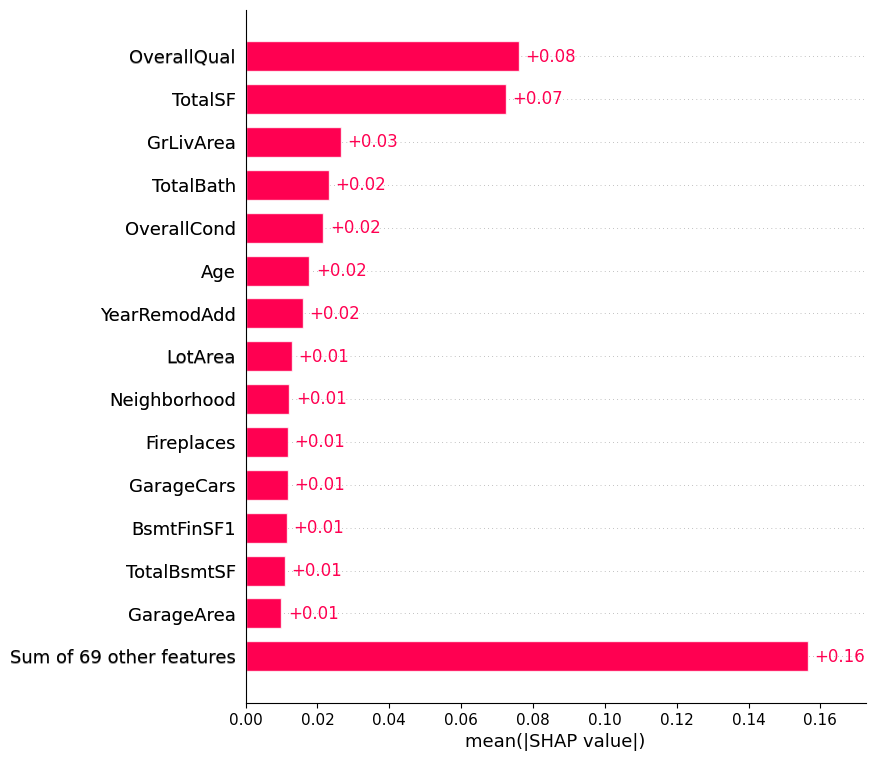


🚀 Training XGB with 5-Fold CV


  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

/usr/local/lib/python3.1


SHAP summary for XGB:


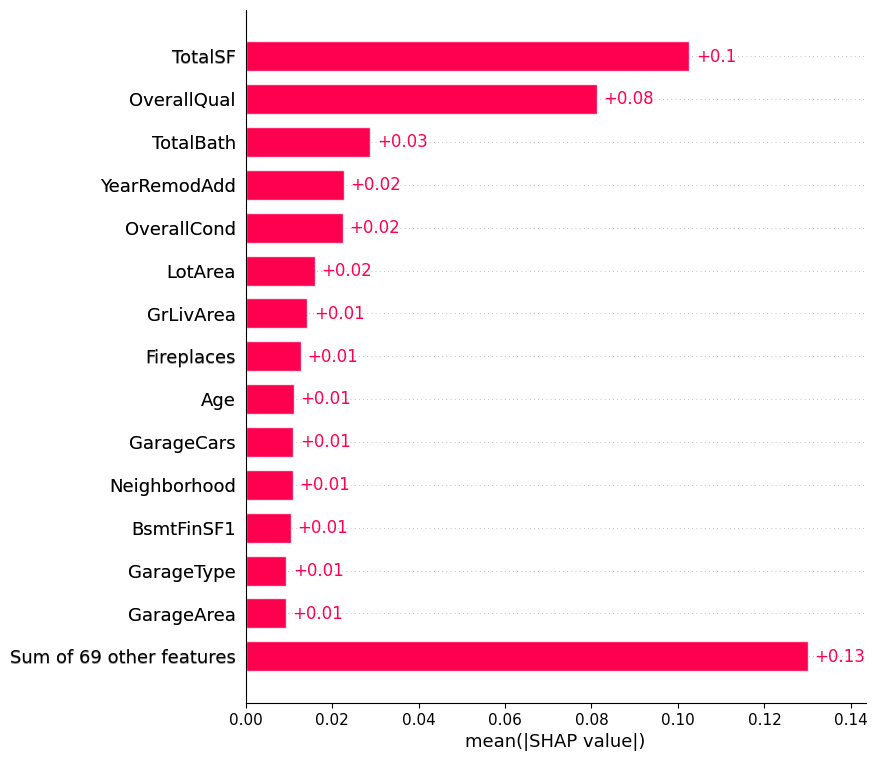


🚀 Training CAT with 5-Fold CV


  0%|          | 0/5 [00:00<?, ?it/s]


SHAP summary for CAT:


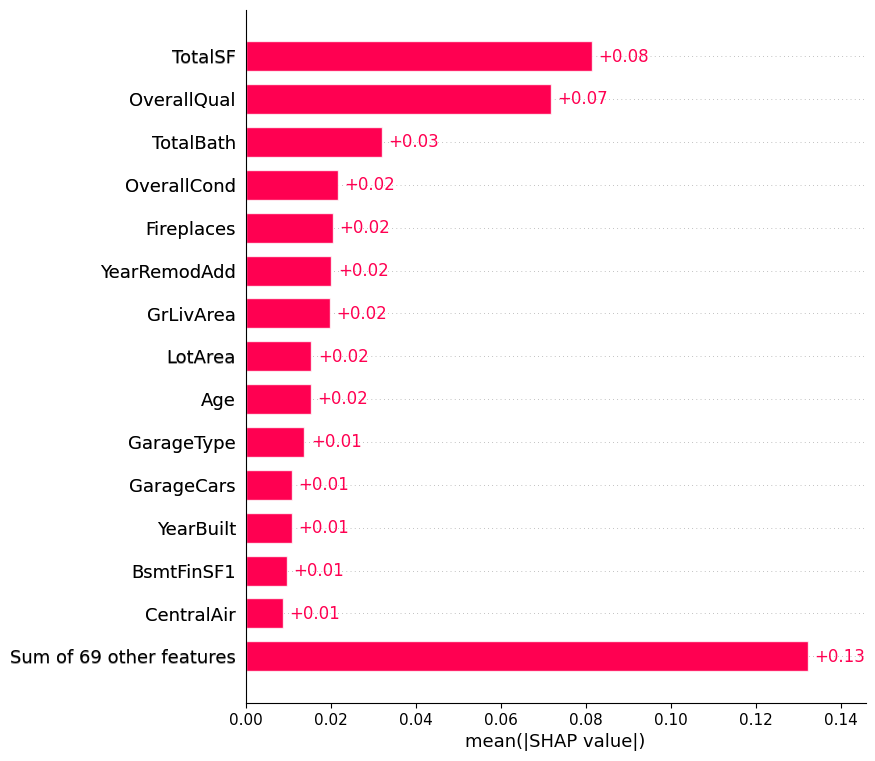

In [12]:
# === Cross-validation Ensemble with TQDM Bar === #
kf = KFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = pd.DataFrame()
test_preds = pd.DataFrame()

for name, model in models.items():
    oof = np.zeros(len(X))
    preds = np.zeros(len(X_test))
    print(f"\n🚀 Training {name} with 5-Fold CV")
    for fold, (train_idx, val_idx) in enumerate(tqdm(kf.split(X), total=5)):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

        if name == 'LGBM':
            model.fit(X_train, y_train,
                      eval_set=[(X_val, y_val)])
        else:
            model.fit(X_train, y_train,
                      eval_set=[(X_val, y_val)],
                      early_stopping_rounds=100 if name != 'CAT' else None,
                      verbose=0)

        oof[val_idx] = model.predict(X_val)
        preds += model.predict(X_test) / kf.n_splits

    oof_preds[name] = oof
    test_preds[name] = preds

    # === SHAP Feature Importance === #
    print(f"\nSHAP summary for {name}:")
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_val)
    shap.plots.bar(shap_values, max_display=15)

<a id = "13"></a><br>
<font color = "DeepSkyBlue">**Stacking with Ridge**

This section uses Ridge regression to stack the predictions from the base models. It trains the stacker on out-of-fold predictions (oof_preds) and generates final predictions on the test set by combining the base models' outputs.

In [13]:
# === Stacking with Ridge === #
stacker = Ridge(alpha=1.0)
stacker.fit(oof_preds, y)
final_preds = stacker.predict(test_preds)

<a id = "14"></a><br>
<font color = "DeepSkyBlue">**Evaluation**

This section evaluates the performance of the stacked model by predicting on the out-of-fold training data and computing the root mean squared error (RMSE). It then prints the final CV RMSE score as a measure of the ensemble's accuracy.

In [14]:
# === Evaluation === #
oof_stacked = stacker.predict(oof_preds)
score = np.sqrt(mean_squared_error(y, oof_stacked))
print(f"\n✅ Stacked CV RMSE: {score:.5f}")


✅ Stacked CV RMSE: 0.12599


<a id = "15"></a><br>
<font color = "DeepSkyBlue">**Final Submission**

This section prepares the final submission file by reversing the earlier log transformation on the predictions using np.expm1, assigning them to the SalePrice column, and saving the results to submission_stacked.csv in the required Kaggle format.

In [15]:
# === Final Submission === #
submission["SalePrice"] = np.expm1(final_preds)
submission.to_csv("submission_stacked.csv", index=False)
print("📤 submission_stacked.csv saved.")

📤 submission_stacked.csv saved.
